<a href="https://colab.research.google.com/github/Onyinye31/A-GNN-APPROACH-TO-DETECTING-AUTOMOBILE-INSURANCE-FRAUD/blob/main/Final_GNN_New_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vehicle Insurance Fraud Detection Dataset

Source:https://www.kaggle.com/datasets/khusheekapoor/vehicle-insurance-fraud-detection

The dataset has 32 features in total, of which there are 25 category features, 6 ordinal features, and one class variable with the label "fraud" or "not-fraud." Only 923 records, out of its 15,420 total records are false.

For data transformation, each column in the relational table is categorised into one of the following three types:

Identity columns – columns that include user or transaction-specific identity data, such as IP addresses, phone numbers, and device identifiers. In the heterogeneous network, these column types are transformed into node types, and the entries in these columns act as nodes.

Categorical columns – columns that are associated with categorical characteristics, such as a user's age range or whether or not a given address is consistent with an address already on file. Numerical feature modification is applied to the items in these columns before they are used as node attributes in the homogeneous graph.

Numerical columns – columns with numerical characteristics, like the quantity of times a user has attempted a transaction. In the heterogeneous graph, the entries in this table are also used as node characteristics. The script makes the assumption that all table columns that aren't identity or category columns are numerical columns.

In [ ]:
%%capture
!git clone https://github.com/joerg84/Graph_Powered_ML_Workshop.git
!rsync -av Graph_Powered_ML_Workshop/ ./ --exclude=.git
!pip3 install dgl
!pip3 install numpy
!pip3 install torch
!pip3 install networkx
!pip3 install matplotlib

In [ ]:
import os, sys
from copy import deepcopy
import numpy as np
import pandas as pd

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(f"Torch version: {th.__version__}.  CUDA version: {th.version.cuda}")

Torch version: 1.13.0+cu116.  CUDA version: 11.6


In [ ]:
dgl_version = f"dgl-cu{th.version.cuda.replace('.', '')}==0.9.1"
dgl_version

'dgl-cu116==0.9.1'

In [ ]:
# Follow instructions at https://www.dgl.ai/pages/start.html
!{sys.executable} -m pip install {dgl_version} -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.3/246.3 MB 4.2 MB/s eta 0:00:00


In [ ]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl import function as fn

In [ ]:
dgl.__version__

'0.9.1'

In [ ]:
import dgl.dataloading

In [ ]:
from dgl.dataloading import NodeDataLoader

In [ ]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

LOAD DATASET

In [ ]:
#load dataset
Dataset = pd.read_csv("/content/carclaims.csv")
#dataset 
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  PolicyNumber          15420 non-null

In [ ]:
#Dataset Description
Dataset.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [ ]:
#Finding Duplicate 
Dataset.duplicated(subset = None, keep = 'first')

0        False
1        False
2        False
3        False
4        False
         ...  
15415    False
15416    False
15417    False
15418    False
15419    False
Length: 15420, dtype: bool

In [ ]:
#No duplicate Present
Dataset.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [ ]:
# drop all rows that have NaN/None values
Dataset2=Dataset.dropna()
print(Dataset2)

      Month  WeekOfMonth  DayOfWeek     Make AccidentArea DayOfWeekClaimed  \
0       Dec            5  Wednesday    Honda        Urban          Tuesday   
1       Jan            3  Wednesday    Honda        Urban           Monday   
2       Oct            5     Friday    Honda        Urban         Thursday   
3       Jun            2   Saturday   Toyota        Rural           Friday   
4       Jan            5     Monday    Honda        Urban          Tuesday   
...     ...          ...        ...      ...          ...              ...   
15415   Nov            4     Friday   Toyota        Urban          Tuesday   
15416   Nov            5   Thursday  Pontiac        Urban           Friday   
15417   Nov            5   Thursday   Toyota        Rural           Friday   
15418   Dec            1     Monday   Toyota        Urban         Thursday   
15419   Dec            2  Wednesday   Toyota        Urban         Thursday   

      MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  .

In [ ]:
# Replace the Labels to 0 and 1
Dataset2.loc[Dataset2['FraudFound'] == 'No','FraudFound'] = 0
Dataset2.loc[Dataset2['FraudFound'] == 'Yes','FraudFound'] = 1

Dataset2['FraudFound'] = Dataset2['FraudFound'].astype(int)

In [ ]:
Dataset2

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,0
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,0
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,0
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,0
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision,1
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability,0
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision,1
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils,0


**EDA / Visualization**

Month - Month in which accident took place

Week of Month - Accident week of month

Day of Week - Accident day of week

Make - Manufacturer of the car (19 companies)

Accident Area - Rural or Urban

Day of Week Claimed - Claim day of week

Month Claimed - Claim month

Week of Month Claimed - Claim week of month

Sex - Male or Female

Marital Status - Single, Married, Widow and Divorced

Age - Age of policy holder

Fault - Policy Holder or Third Party

Policy Type - Type of policy (1 to 9)
Vehicle Category - Sedan, Sport or Utility

Vehicle Price - Price of the vehicle with 6 categories

Policy Number- Index of the Policy

Rep. Number - ID of the person who process the claim (16 IDs)

Deductible - Amount to be deducted before claim disbursement

Driver Rating - Driving Experience with 4 categories

Days Policy Accident - Days left in policy when accident happened

Days Policy Claim - Days left in policy when claim was filed

Past number of Claims - Past number of claims

Age of Vehicle - Vehicle's age with 8 categories

Age of Policy Holder - Policy 
holder's age with 9 categories

Police Report Filed – Yes (1) or no (0)

Witness Present – Yes (1) or no (0)

Agent Type - Internal or External

Number of Supplements - Number of supplements

Address Change Claim – No. of times change of address requested

Number of Cars - Number of cars owned by the person claiming insurance

Year - 1994, 1995 and 1996

Base Policy - All perils, Collision or Liability

FraudFound_P - Fraud found (yes '1' or no '0')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

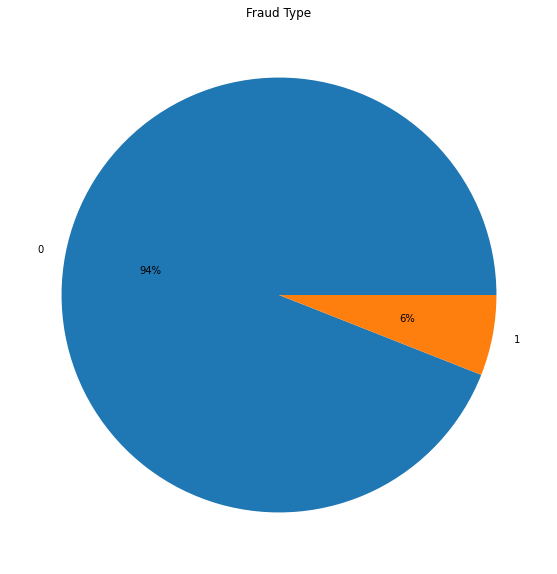

In [ ]:
#Fraud Type Percentage
plt.figure(figsize=(20,10))
plt.pie(Dataset2.FraudFound.value_counts().values,labels=Dataset2.FraudFound.value_counts().index,  autopct='%.0f%%')
plt.title("Fraud Type")
plt.show()

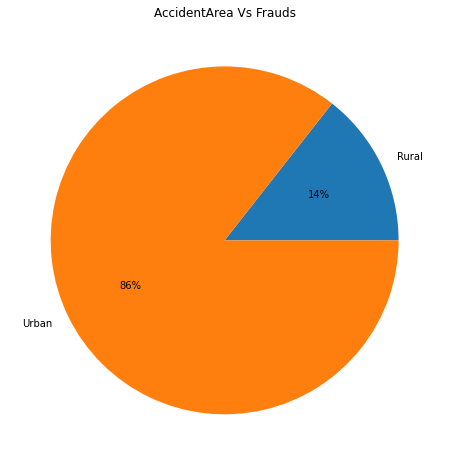

In [ ]:
accidentArea = Dataset2.groupby('AccidentArea')['FraudFound'].sum()

plt.figure(figsize=(10,8))
plt.title("AccidentArea Vs Frauds")

plt.pie(accidentArea.values,labels=accidentArea.index,  autopct='%.0f%%')

plt.show()

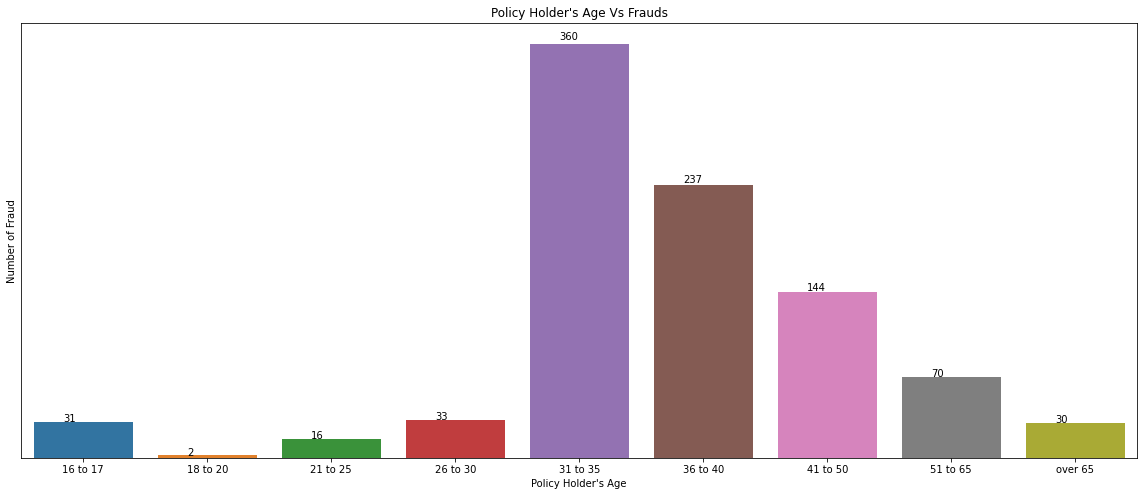

In [ ]:
policyAge = Dataset2.groupby('AgeOfPolicyHolder')['FraudFound'].sum()
plt.figure(figsize=(20,8))
plt.title("Policy Holder's Age Vs Frauds")

ax = sns.barplot(x=policyAge.index,y=policyAge.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))
plt.xlabel("Policy Holder's Age")
plt.ylabel("Number of Fraud");
plt.yticks([])
plt.show()

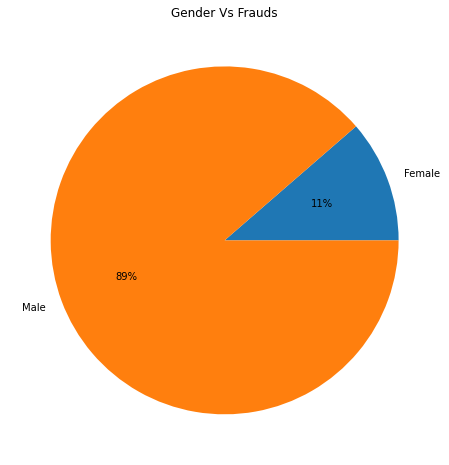

In [ ]:
gender = Dataset2.groupby('Sex')['FraudFound'].sum()
plt.figure(figsize=(10,8))
plt.title("Gender Vs Frauds")

plt.pie(gender.values,labels=gender.index,  autopct='%.0f%%')

plt.show()

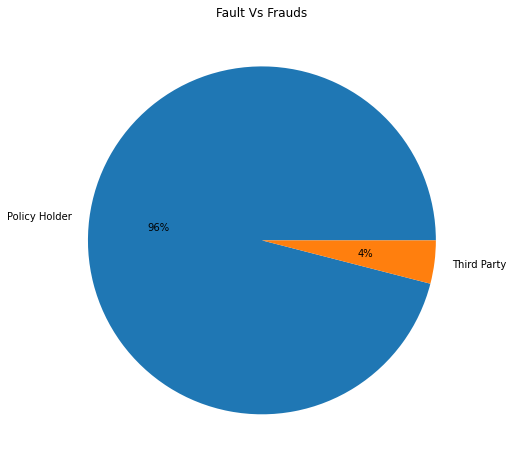

In [ ]:
fault = Dataset2.groupby('Fault')['FraudFound'].sum()

plt.figure(figsize=(10,8))
plt.title("Fault Vs Frauds")
plt.pie(fault.values,labels=fault.index,  autopct='%.0f%%')
plt.show()

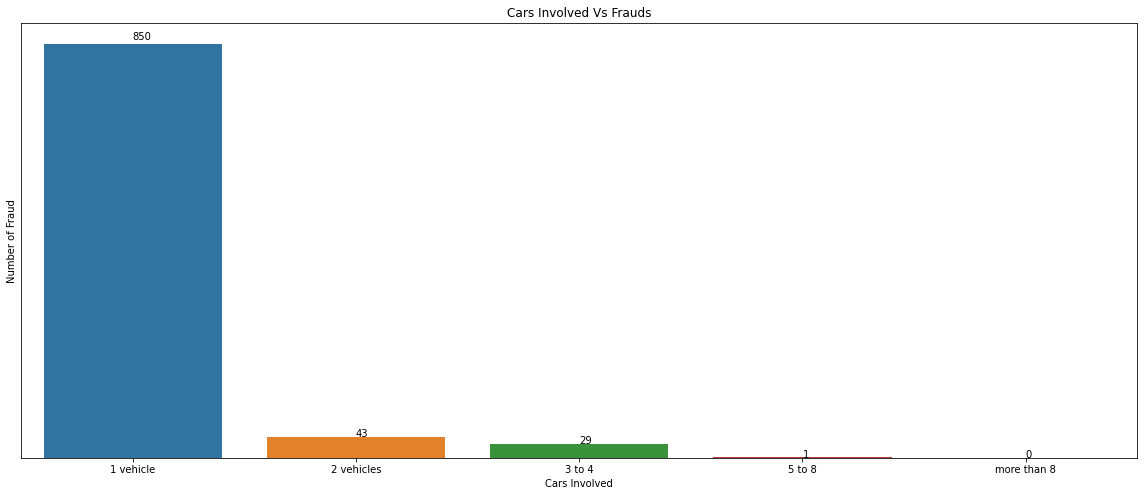

In [ ]:
cars = Dataset2.groupby('NumberOfCars')['FraudFound'].sum()
plt.figure(figsize=(20,8))
plt.title("Cars Involved Vs Frauds")

ax = sns.barplot(x=cars.index,y=cars.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.4, p.get_height()*1.01))
plt.xlabel("Cars Involved")
plt.ylabel("Number of Fraud");
plt.yticks([])
plt.show()

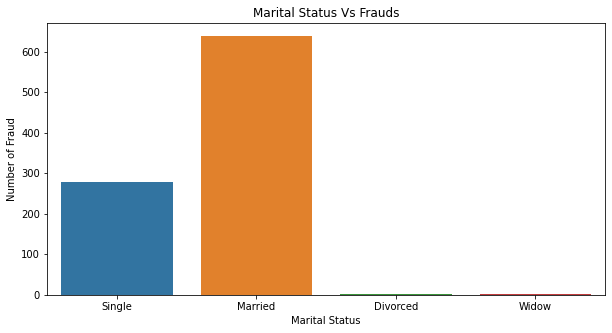

In [ ]:
fraud = Dataset2[Dataset2['FraudFound'] == 1]
plt.figure(figsize=(10,5))
plt.title("Marital Status Vs Frauds")
sns.countplot(x=fraud['MaritalStatus']);
plt.xlabel("Marital Status")
plt.ylabel("Number of Fraud");

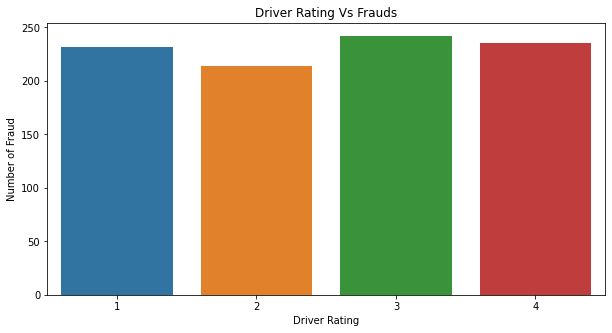

In [ ]:
fraud = Dataset2[Dataset2['FraudFound'] == 1]
plt.figure(figsize=(10,5))
plt.title("Driver Rating Vs Frauds")
sns.countplot(x=fraud['DriverRating']);
plt.xlabel("Driver Rating")
plt.ylabel("Number of Fraud");

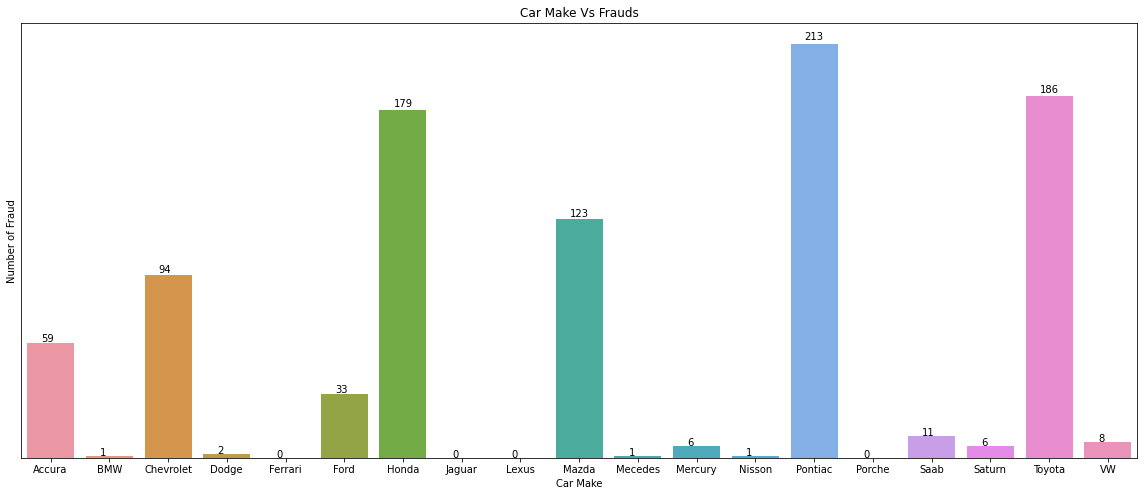

In [ ]:
make = Dataset2.groupby('Make')['FraudFound'].sum()
plt.figure(figsize=(20,8))
plt.title("Car Make Vs Frauds")

ax = sns.barplot(x=make.index,y=make.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))
plt.xlabel("Car Make")
plt.ylabel("Number of Fraud");
plt.yticks([])
plt.show()

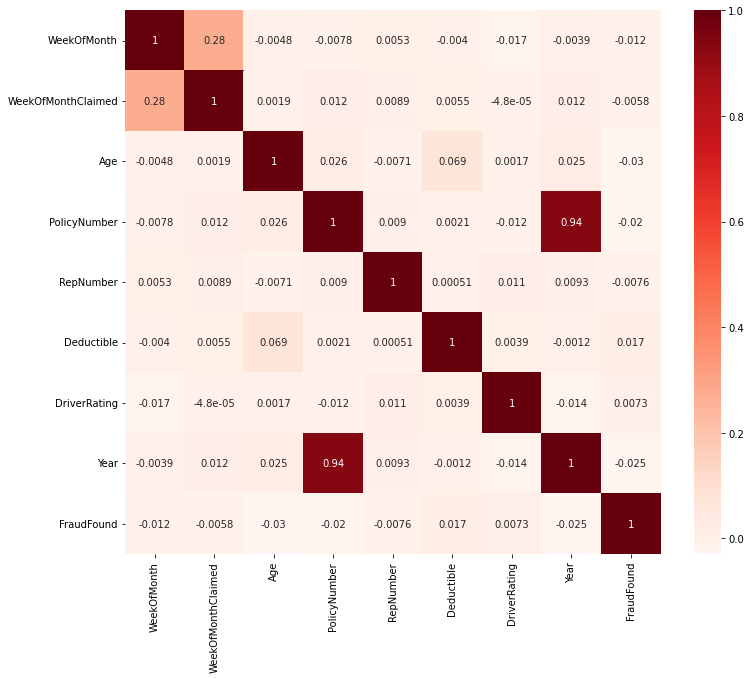

In [ ]:
plt.figure(figsize=(12,10))
cor = Dataset2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
Dataset2.nunique().T

Month                      12
WeekOfMonth                 5
DayOfWeek                   7
Make                       19
AccidentArea                2
DayOfWeekClaimed            8
MonthClaimed               13
WeekOfMonthClaimed          5
Sex                         2
MaritalStatus               4
Age                        66
Fault                       2
PolicyType                  9
VehicleCategory             3
VehiclePrice                6
PolicyNumber            15420
RepNumber                  16
Deductible                  4
DriverRating                4
Days:Policy-Accident        5
Days:Policy-Claim           4
PastNumberOfClaims          4
AgeOfVehicle                8
AgeOfPolicyHolder           9
PoliceReportFiled           2
WitnessPresent              2
AgentType                   2
NumberOfSuppliments         4
AddressChange-Claim         5
NumberOfCars                5
Year                        3
BasePolicy                  3
FraudFound                  2
dtype: int

**Conclusions:**

PolicyNumber is unique, and the level at which predictions should be made. We will create nodes and make this a node classification problem.


Attributes with a handful of unique are candidates for (categorical) features of nodes 


DiverRating will be the Edge 

FraudFound is the label 



In [ ]:
#selected based on discretion 
df = Dataset2[['PolicyNumber','AccidentArea','Sex',\
       'MaritalStatus','Fault','DriverRating','RepNumber',\
       'PoliceReportFiled', 'WitnessPresent',\
       'BasePolicy', 'FraudFound']]

**Experiment 1**

**Converting Dataset to Graph Data**

In [ ]:
max(df["PolicyNumber"].value_counts())

1

NODE

In [ ]:
# Sort to define the order of nodes
sorted_df = df.sort_values(by="PolicyNumber")
# Select node features
node_features = sorted_df[['AccidentArea','Sex',\
       'MaritalStatus','Fault','RepNumber','BasePolicy',\
       'PoliceReportFiled', 'WitnessPresent']]

In [ ]:
# Convert non-numeric columns
pd.set_option('mode.chained_assignment', None)
#positions = node_features.str.split(",", expand=True)
#node_features["first_position"] = positions[0]

In [ ]:
X_ohe = pd.get_dummies(node_features.astype(str), drop_first=True)


In [ ]:
X_ohe.head()

,AccidentArea_Urban,Sex_Male,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,Fault_Third Party,RepNumber_10,RepNumber_11,RepNumber_12,RepNumber_13,...,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,BasePolicy_Collision,BasePolicy_Liability,PoliceReportFiled_Yes,WitnessPresent_Yes
0,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Convert to numpy
x = X_ohe.to_numpy()
x.shape

(15420, 25)

In [ ]:
from sklearn import preprocessing

X= preprocessing.normalize(x)

In [ ]:
X

array([[0.5       , 0.        , 0.        , ..., 0.5       , 0.        ,
        0.        ],
       [0.40824829, 0.40824829, 0.        , ..., 0.        , 0.40824829,
        0.        ],
       [0.4472136 , 0.4472136 , 0.4472136 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.5       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.4472136 , 0.4472136 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

LABELS

In [ ]:
#labels
sorted_df = df.sort_values(by="PolicyNumber")
# Select labels
labels = sorted_df["FraudFound"]
labels.head()

0    0
1    0
2    0
3    0
4    0
Name: FraudFound, dtype: int64

In [ ]:
# Convert to numpy
y = labels.to_numpy()
y.shape

(15420,)

In [ ]:
y

array([0, 0, 0, ..., 1, 0, 1])

EDGES

In [ ]:
# Remap 
df["PolicyNumber"] = df.reset_index().index

In [ ]:
df["DriverRating"].value_counts()

1    3944
3    3884
2    3801
4    3791
Name: DriverRating, dtype: int64

In [ ]:
import itertools
import numpy as np

types = df["DriverRating"].unique()
all_edges = np.array([], dtype=np.int32).reshape((0, 2))
for base in types:
    types_df = df[df["DriverRating"] == base]
    individuals = types_df["PolicyNumber"].values
    # Build all combinations
    permutations = list(itertools.combinations(individuals, 2))
    edges_source = [e[0] for e in permutations]
    edges_target = [e[1] for e in permutations]
    types_edges = np.column_stack([edges_source, edges_target])
    all_edges = np.vstack([all_edges, types_edges])
# Convert to Pytorch Geometric format
edge_index = all_edges.transpose()
edge_index # [2, num_edges]

array([[    0,     0,     0, ..., 15403, 15403, 15404],
       [    4,     6,     9, ..., 15404, 15413, 15413]])

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.13.0+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 6.2 MB/s eta 0:00:00


In [ ]:
X=X.astype(np.float32)

In [ ]:
X

array([[0.5      , 0.       , 0.       , ..., 0.5      , 0.       ,
        0.       ],
       [0.4082483, 0.4082483, 0.       , ..., 0.       , 0.4082483,
        0.       ],
       [0.4472136, 0.4472136, 0.4472136, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.5      , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.5      , 0.       , 0.5      , ..., 0.       , 0.       ,
        0.       ],
       [0.4472136, 0.4472136, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
from torch_geometric.data import Data

In [ ]:
data = Data(x=torch.tensor(X), edge_index=torch.tensor(edge_index), y=torch.tensor(y) , num_classes = 2 ) 

In [ ]:
#data = Data(x=torch.tensor(X), edge_index=torch.tensor(edge_index), y=torch.tensor(y) ) 

In [ ]:
data

Data(x=[15420, 25], edge_index=[2, 29722227], y=[15420], num_classes=2)

In [ ]:
data.x

tensor([[0.5000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [0.4082, 0.4082, 0.0000,  ..., 0.0000, 0.4082, 0.0000],
        [0.4472, 0.4472, 0.4472,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4472, 0.4472, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
data.edge_index

tensor([[    0,     0,     0,  ..., 15403, 15403, 15404],
        [    4,     6,     9,  ..., 15404, 15413, 15413]])

In [ ]:
data.y

tensor([0, 0, 0,  ..., 1, 0, 1])

Split to training and testing 

In [ ]:
train_ratio = 0.2
num_nodes = data.x.shape[0]
num_train = int(num_nodes * train_ratio)
idx = [i for i in range(num_nodes)]

In [ ]:
np.random.shuffle(idx)
train_mask = torch.full_like(data.y, False, dtype=bool)
train_mask[idx[:num_train]] = True
test_mask = torch.full_like(data.y, False, dtype=bool)
test_mask[idx[num_train:]] = True

In [ ]:
print(train_mask)
# tensor([ True, False, False, False, False])
print(test_mask)
# tensor([False,  True,  True,  True,  True])

tensor([False, False, False,  ..., False, False, False])
tensor([True, True, True,  ..., True, True, True])


In [ ]:

# check number of edges of the graph
print(data.num_edges)

29722227


In [ ]:

# check number of nodes of the graph
print(data.num_nodes)
     

15420


In [ ]:

# check number of features of the graph
print(data.num_features)

25


In [ ]:

# check if graph is directed
print(data.is_directed())

True


In [ ]:
data.edge_index

tensor([[    0,     0,     0,  ..., 15403, 15403, 15404],
        [    4,     6,     9,  ..., 15404, 15413, 15413]])

In [ ]:
data.x

tensor([[0.5000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [0.4082, 0.4082, 0.0000,  ..., 0.0000, 0.4082, 0.0000],
        [0.4472, 0.4472, 0.4472,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4472, 0.4472, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

Number of nodes: 15420
Number of edges: 29722227
Average node degree: 1927.51


In [ ]:
print(f'Number of graphs: {len(data)}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {data.num_classes}')

Number of graphs: 4
Number of features: 25
Number of classes: 2


**GNN MODEL**

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, data.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(25, 16)
  (conv2): GCNConv(16, 2)
)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


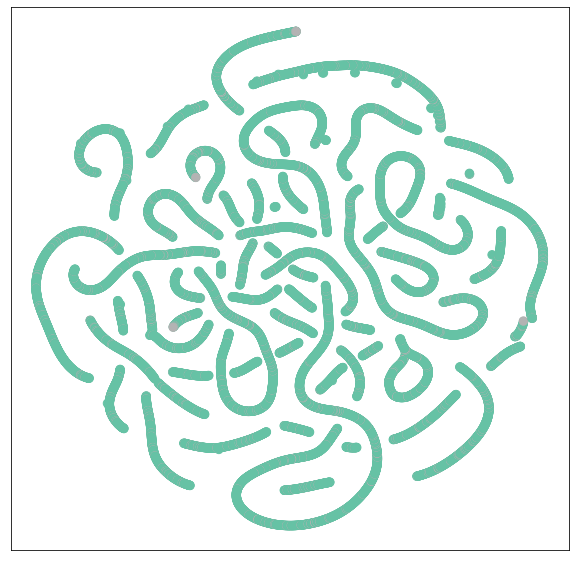

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      output = pred[test_mask]
      return output
    

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.5233
Epoch: 002, Loss: 0.3862
Epoch: 003, Loss: 0.3014
Epoch: 004, Loss: 0.2424
Epoch: 005, Loss: 0.2144
Epoch: 006, Loss: 0.1998
Epoch: 007, Loss: 0.1975
Epoch: 008, Loss: 0.2001
Epoch: 009, Loss: 0.2055
Epoch: 010, Loss: 0.2120
Epoch: 011, Loss: 0.2167
Epoch: 012, Loss: 0.2210
Epoch: 013, Loss: 0.2251
Epoch: 014, Loss: 0.2262
Epoch: 015, Loss: 0.2290
Epoch: 016, Loss: 0.2277
Epoch: 017, Loss: 0.2246
Epoch: 018, Loss: 0.2232
Epoch: 019, Loss: 0.2186
Epoch: 020, Loss: 0.2133
Epoch: 021, Loss: 0.2095
Epoch: 022, Loss: 0.2062
Epoch: 023, Loss: 0.2022
Epoch: 024, Loss: 0.1989
Epoch: 025, Loss: 0.1977
Epoch: 026, Loss: 0.1980
Epoch: 027, Loss: 0.1992
Epoch: 028, Loss: 0.2009
Epoch: 029, Loss: 0.2030
Epoch: 030, Loss: 0.2025
Epoch: 031, Loss: 0.2013
Epoch: 032, Loss: 0.2022
Epoch: 033, Loss: 0.2001
Epoch: 034, Loss: 0.1998
Epoch: 035, Loss: 0.1989
Epoch: 036, Loss: 0.1982
Epoch: 037, Loss: 0.1982
Epoch: 038, Loss: 0.1974
Epoch: 039, Loss: 0.1977
Epoch: 040, Loss: 0.1980


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9375


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
output = test()

In [ ]:
print('Accuracy: %.3f' % accuracy_score(data.y[test_mask],output))

Accuracy: 0.938


In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
print(classification_report(data.y[test_mask],output))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     11565
           1       0.00      0.00      0.00       771

    accuracy                           0.94     12336
   macro avg       0.47      0.50      0.48     12336
weighted avg       0.88      0.94      0.91     12336



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
